In [1]:
import cv2
import albumentations as A
from pathlib import Path
import random
from tqdm import tqdm
import yaml
import shutil
import pandas as pd
import logging
import time
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_YAML_PATH = Path(r"C:\Users\Admin\Desktop\NEU 4\Computer Vision\Midterm\Object Detection\Object Detection\Data\data.yaml")
DATA_ROOT = DATA_YAML_PATH.parent

# Directory name for the balanced dataset
BALANCED_DATA_DIR = DATA_ROOT.parent / "Data_balanced"

MIN_THRESHOLD = 200      # Classes with fewer than this number will be oversampled
TARGET_COUNT = 400       # Oversample to reach this quantity
MAX_THRESHOLD = 2000     # Classes with more than this number will be undersampled
UNDERSAMPLE_RATIO = 0.6  # Keep 60% of images containing only this class
LOG_FILE_PATH = BALANCED_DATA_DIR / "augmentation_errors.log" 

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.2),
    A.Rotate(limit=25, p=0.6, border_mode=cv2.BORDER_CONSTANT),
    A.Blur(blur_limit=4, p=0.2),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.1))

def get_class_distribution(label_dir, class_names):
    """Count the number of instances and map images to the classes they contain."""
    class_counts = {i: 0 for i in range(len(class_names))}
    image_to_classes = {}
    
    for label_path in tqdm(list(label_dir.glob("*.txt")), desc="Analyzing distribution"):
        image_stem = label_path.stem
        image_to_classes[image_stem] = set()
        with open(label_path, 'r') as f:
            for line in f.readlines():
                try:
                    class_id = int(line.strip().split()[0])
                    class_counts[class_id] += 1
                    image_to_classes[image_stem].add(class_id)
                except (ValueError, IndexError):
                    continue
    return class_counts, image_to_classes

def balance_dataset():
    """Perform both oversampling and undersampling to create a new dataset."""
    
    # --- 1. Reading configuration and preparing directories ---
    print(">>> Step 1: Reading configuration and preparing directories...")
    with open(DATA_YAML_PATH, 'r') as f:
        data_config = yaml.safe_load(f)
    class_names = data_config['names']

    
    # Create new directory for the balanced dataset
    if BALANCED_DATA_DIR.exists():
        print(f"Directory '{BALANCED_DATA_DIR.name}' already exists. Please delete or rename it.")
        logging.shutdown()
        attempts = 5
        for i in range(attempts):
            try:
                shutil.rmtree(BALANCED_DATA_DIR)
                print("Successfully deleted old directory.")
                break 
            except PermissionError as e:
                if i < attempts - 1:
                    print(f"PermissionError, retrying in 1 second... (Attempt {i+1}/{attempts})")
                    time.sleep(1) 
                else:
                    print(f"Could not delete directory '{BALANCED_DATA_DIR.name}' after {attempts} attempts.")
                    raise e 
    
    # Copy the entire directory structure (train, valid, test)
    print(f"Copying original data from '{DATA_ROOT.name}' to '{BALANCED_DATA_DIR.name}'...")
    shutil.copytree(DATA_ROOT, BALANCED_DATA_DIR)

    LOG_FILE_PATH = BALANCED_DATA_DIR / "augmentation_errors.log"
    logging.basicConfig(filename=LOG_FILE_PATH, level=logging.INFO, 
                        format='%(asctime)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S',
                        force=True) 

    train_image_dir = BALANCED_DATA_DIR / "train" / "images"
    train_label_dir = BALANCED_DATA_DIR / "train" / "labels"

    # --- 2. Analyzing class distribution of the training set ---
    print("\n>>> Step 2: Analyzing class distribution of the training set...")
    class_counts, image_to_classes = get_class_distribution(train_label_dir, class_names)
    
    minority_classes = {cid for cid, count in class_counts.items() if count < MIN_THRESHOLD}
    majority_classes = {cid for cid, count in class_counts.items() if count > MAX_THRESHOLD}
    
    print(f"Found {len(minority_classes)} minority classes (< {MIN_THRESHOLD} instances).")
    print(f"Found {len(majority_classes)} majority classes (> {MAX_THRESHOLD} instances).")
    
    images_to_oversample = {stem for stem, classes in image_to_classes.items() if minority_classes.intersection(classes)}
    
    # --- 3. Oversampling (Augmenting minority classes) ---
    print("\n>>> Step 3: Performing Oversampling...")

    total_augmentations_attempted = 0
    successful_augmentations = 0
    failed_augmentations = 0
    for image_stem in tqdm(images_to_oversample, desc="Oversampling minority classes"):
        label_path = train_label_dir / (image_stem + ".txt")
        image_path = train_image_dir / (image_stem + ".jpg") 
        if not image_path.exists(): image_path = train_image_dir / (image_stem + ".png")
        if not image_path.exists(): continue
            
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        bboxes = [[float(p) for p in line.strip().split()[1:]] for line in lines]
        class_labels = [int(line.strip().split()[0]) for line in lines]
        
        # Calculate number of augmentations needed to reach the target
        current_min_count = min(class_counts[cid] for cid in class_labels if cid in minority_classes)
        if current_min_count == 0: continue
        num_replications = max(1, round(TARGET_COUNT / current_min_count) - 1)
        
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        for i in range(num_replications):
            total_augmentations_attempted += 1
            try:
                transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
                
                if not transformed['bboxes']:
                    failed_augmentations += 1
                    log_message = f"FAIL_VISIBILITY - File: {image_stem} - Augmentation attempt {i+1}/{num_replications} - Reason: All bboxes were removed due to min_visibility."
                    logging.info(log_message)
                    continue

                # Create new file name
                new_stem = f"{image_stem}_ovs_{i}"
                
                # Saving new image and labels
                cv2.imwrite(str(train_image_dir / f"{new_stem}.jpg"), cv2.cvtColor(transformed['image'], cv2.COLOR_BGR2RGB))
                with open(train_label_dir / f"{new_stem}.txt", 'w') as f_out:
                    for bbox, label in zip(transformed['bboxes'], transformed['class_labels']):
                        f_out.write(f"{int(label)} {' '.join(map(str, bbox))}\n")
                
                successful_augmentations += 1

            except ValueError as e:
                # Catching specific ValueError from albumentations
                failed_augmentations += 1
                # Log detailed error
                log_message = f"FAIL_VALUE_ERROR - File: {image_stem} - Augmentation attempt {i+1}/{num_replications} - Error: {e}"
                logging.info(log_message)
                continue
            except Exception as e:
                # Catching other unexpected errors
                failed_augmentations += 1
                log_message = f"FAIL_UNKNOWN_ERROR - File: {image_stem} - Augmentation attempt {i+1}/{num_replications} - Error: {e}"
                logging.info(log_message)
                continue
    # Printing summary report
    print("\n" + "-"*50)
    print("Oversampling Process Report:")
    print(f"  - Total augmentation attempts: {total_augmentations_attempted}")
    print(f"  - Successful: {successful_augmentations}")
    print(f"  - Failed: {failed_augmentations}")
    if failed_augmentations > 0:
        print(f"  - Details of errors have been logged to the file: {LOG_FILE_PATH}")
    print("-" * 50)
    
    # --- 4. Undersampling (Reducing majority classes) ---
    print("\n>>> Step 4: Performing Undersampling...")
    images_to_remove = []
    _, image_to_classes_updated = get_class_distribution(train_label_dir, class_names)
    
    for image_stem, classes in tqdm(image_to_classes_updated.items(), desc="Undersampling majority classes"):
        if classes.issubset(majority_classes) and not "_ovs_" in image_stem:
            if random.random() > UNDERSAMPLE_RATIO:
                images_to_remove.append(image_stem)
    
    print(f"Will delete {len(images_to_remove)} images containing only majority classes...")
    for image_stem in images_to_remove:
        for ext in ['.jpg', '.png', '.jpeg']:
            if (train_image_dir / (image_stem + ext)).exists():
                (train_image_dir / (image_stem + ext)).unlink()
                break
        if (train_label_dir / (image_stem + '.txt')).exists():
            (train_label_dir / (image_stem + '.txt')).unlink()
            
    # --- 5. Completion ---
    print("\n>>> Completed! The balanced dataset has been saved at:", BALANCED_DATA_DIR)
    print("Please update the data.yaml file in that directory (if necessary) and point your training path there.")

c:\Python310\lib\site-packages\albumentations\augmentations\blur\functional.py:232: UserWarning: blur_limit: Non-zero kernel sizes must be odd. Range (3, 4) automatically adjusted to (3, 5).
  result = _ensure_odd_values(result, info.field_name)


In [3]:
balance_dataset()

>>> Step 1: Reading configuration and preparing directories...
Directory 'Data_balanced' already exists. Please delete or rename it.
Successfully deleted old directory.
Copying original data from 'Data' to 'Data_balanced'...

>>> Step 2: Analyzing class distribution of the training set...


Analyzing distribution: 100%|██████████| 13605/13605 [04:02<00:00, 56.19it/s]


Found 30 minority classes (< 200 instances).
Found 1 majority classes (> 2000 instances).

>>> Step 3: Performing Oversampling...


Oversampling minority classes: 100%|██████████| 3141/3141 [06:25<00:00,  8.16it/s]



--------------------------------------------------
Oversampling Process Report:
  - Total augmentation attempts: 7581
  - Successful: 7165
  - Failed: 416
  - Details of errors have been logged to the file: C:\Users\Admin\Desktop\NEU 4\Computer Vision\Midterm\Object Detection\Object Detection\Data_balanced\augmentation_errors.log
--------------------------------------------------

>>> Step 4: Performing Undersampling...


Undersampling majority classes: 100%|██████████| 20770/20770 [00:00<00:00, 2172677.92it/s]


Will delete 694 images containing only majority classes...

>>> Completed! The balanced dataset has been saved at: C:\Users\Admin\Desktop\NEU 4\Computer Vision\Midterm\Object Detection\Object Detection\Data_balanced
Please update the data.yaml file in that directory (if necessary) and point your training path there.


In [15]:
def analyze_dataset(data_yaml_path):
    """
    Comprehensive analysis function for a YOLO dataset.
    """
    # --- 1. YAML File Analysis ---
    print("="*50)
    print("1. DATA.YAML FILE ANALYSIS")
    print("="*50)
    try:
        with open(data_yaml_path, 'r') as f:
            data_config = yaml.safe_load(f)
        
        # Get the dataset root directory from the yaml file location
        dataset_root = data_yaml_path.parent
        
        def resolve_split_path(config_key):
            yaml_value = data_config.get(config_key, '')
            if not yaml_value:
                return dataset_root / Path(f"MISSING_{config_key}")
            
            p = Path(yaml_value)

            try:
                split_folder = p.parts[-2] # e.g., 'train' from '../train/images'
                data_type = p.parts[-1] # e.g., 'images'
            except IndexError:
                return (dataset_root / yaml_value).resolve()
        
            return (dataset_root / split_folder / data_type).resolve()
        
        train_path = resolve_split_path('train')
        val_path = resolve_split_path('val')
        test_path = resolve_split_path('test')
        
        class_names = data_config['names']
        num_classes = data_config['nc']
        
        print(f"YAML file loaded successfully.")
        print(f"   - Number of classes (nc): {num_classes}")
        print(f"   - Class names: {class_names}")
        print(f"   - Train Path: {train_path}")
        print(f"   - Val Path: {val_path}")
        print(f"   - Test Path: {test_path}")

        # Check if the number of class names matches nc
        if len(class_names) != num_classes:
            print(f"Warning: Number of class names ({len(class_names)}) does not match nc ({num_classes})!")
            
    except Exception as e:
        print(f"Error reading YAML file: {e}")
        return

    # --- 2. Integrity Check (Images vs. Labels) ---
    print("\n" + "="*50)
    print("2. INTEGRITY CHECK (IMAGE vs. LABEL) - DEBUG MODE")
    print("="*50)

    stats = {}
    for split_name, image_dir in [('Train', train_path), ('Val', val_path), ('Test', test_path)]:
        print(f"\n>>> Processing split: {split_name}")
        print(f"   - 'image_dir' variable received: {image_dir}")
        
        if not image_dir or not image_dir.exists():
            print(f"STATUS: Skipped because the path does not exist.")
            continue
        
        # Calculate labels path
        label_dir = image_dir.with_name('labels')
        
        # --- DEBUG: Print labels path and check existence ---
        print(f"Calculated 'label_dir' path: {label_dir}")
        if not label_dir.exists():
            print(f"STATUS: LABELS DIRECTORY DOES NOT EXIST!")
            # Do not assign stats and continue the loop to avoid errors later
            continue 
        else:
            print(f"STATUS: Labels directory found.")

        image_files = {p.stem for p in image_dir.glob('*.[jp][pn]g')}
        label_files = {p.stem for p in label_dir.glob('*.txt')}
        
        # --- DEBUG: Print number of files found ---
        print(f"   - Number of image files found (.jpg, .png): {len(image_files)}")
        print(f"   - Number of label files found (.txt): {len(label_files)}")
        
        if len(label_files) == 0:
            print("WARNING: No label files found. Section 3 will have no data to process.")
            # Still save stats so later sections don't fail, but there will be no data
            stats[split_name] = {'image_dir': image_dir, 'label_dir': label_dir}
            continue
            
        images_no_labels = image_files - label_files
        labels_no_images = label_files - image_files
        
        print(f"--- Analysis for {split_name} split ---")
        print(f"   - Total images: {len(image_files)}")
        print(f"   - Total label files: {len(label_files)}")
        
        if not images_no_labels and not labels_no_images:
            print("Status: Perfect! Every image has a label, and vice-versa.")
        else:
            if images_no_labels:
                print(f"{len(images_no_labels)} images missing label files. Example: {list(images_no_labels)[:3]}")
            if labels_no_images:
                print(f"{len(labels_no_images)} label files missing corresponding images. Example: {list(labels_no_images)[:3]}")
        
        stats[split_name] = {'image_dir': image_dir, 'label_dir': label_dir}

    # --- 3. Class Distribution Analysis ---
    print("\n" + "="*50)
    print("3. CLASS DISTRIBUTION ANALYSIS")
    print("="*50)

    class_counts = {name: 0 for name in class_names.values()}
    all_boxes = []

    for split_name, split_info in stats.items():
        if 'label_dir' not in split_info or not split_info['label_dir'].exists():
            continue
            
        for label_file in tqdm(split_info['label_dir'].glob('*.txt'), desc=f"Reading labels for {split_name}"):
            with open(label_file, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        class_name = class_names[class_id]
                        class_counts[class_name] += 1
                        
                        # Collect data for bounding box size analysis
                        w = float(parts[3])
                        h = float(parts[4])
                        all_boxes.append({'class': class_name, 'width': w, 'height': h, 'area': w * h})

    class_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count']).sort_values('Count', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Class', data=class_df)
    plt.title('Instance Count per Class')
    plt.xlabel('Count')
    plt.ylabel('Class')
    plt.show()
    
    print("Instance Count Statistics Table:")
    print(class_df)
    
    # --- 4. Bounding Box Size Analysis ---
    print("\n" + "="*50)
    print("4. BOUNDING BOX SIZE ANALYSIS")
    print("="*50)
    
    if all_boxes:
        box_df = pd.DataFrame(all_boxes)
        box_df['width_pixels'] = box_df['width'] * 640 # Assuming image size is 640
        box_df['height_pixels'] = box_df['height'] * 640

        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=box_df, x='width_pixels', y='height_pixels', hue='class', alpha=0.5, legend=None)
        plt.title('Bounding Box Size Distribution (Width vs. Height)')
        plt.xlabel('Width (pixels, assuming 640px image)')
        plt.ylabel('Height (pixels, assuming 640px image)')
        plt.grid(True)
        plt.show()
        
        print("This chart shows the clustering of objects by size.")
        print("If all points concentrate in the bottom-left corner -> Data contains many small objects.")
        print("If points are scattered -> Object sizes are diverse.")
        
    # --- 5. Visualize Sample Data ---
    print("\n" + "="*50)
    print("5. DATA SAMPLE VISUALIZATION")
    print("="*50)
    
    num_samples_to_show = 9
    
    if 'Train' in stats and stats['Train']['image_dir'].exists():
        image_files = list(stats['Train']['image_dir'].glob('*.[jp][pn]g'))
        if image_files:
            sample_images = random.sample(image_files, min(num_samples_to_show, len(image_files)))
            
            cols = 3
            rows = (len(sample_images) + cols - 1) // cols
            fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
            axes = axes.flatten()

            for i, img_path in enumerate(sample_images):
                img = cv2.imread(str(img_path))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                h, w, _ = img.shape
                
                label_path = stats['Train']['label_dir'] / (img_path.stem + '.txt')
                if label_path.exists():
                    with open(label_path, 'r') as f:
                        for line in f.readlines():
                            parts = line.strip().split()
                            class_id = int(parts[0])
                            x_center, y_center, box_w, box_h = map(float, parts[1:])
                            
                            x1 = int((x_center - box_w / 2) * w)
                            y1 = int((y_center - box_h / 2) * h)
                            x2 = int((x_center + box_w / 2) * w)
                            y2 = int((y_center + box_h / 2) * h)
                            
                            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                            cv2.putText(img, class_names[class_id], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)

                axes[i].imshow(img)
                axes[i].set_title(img_path.name)
                axes[i].axis('off')

            for j in range(i + 1, len(axes)):
                axes[j].axis('off')

            plt.tight_layout()
            plt.show()

1. DATA.YAML FILE ANALYSIS
YAML file loaded successfully.
   - Number of classes (nc): 54
   - Class names: {0: 'Zebra', 1: 'Lion', 2: 'Leopard', 3: 'Cheetah', 4: 'Tiger', 5: 'Bear', 6: 'Butterfly', 7: 'Canary', 8: 'Crocodile', 9: 'Bull', 10: 'Camel', 11: 'Centipede', 12: 'Caterpillar', 13: 'Duck', 14: 'Squirrel', 15: 'Spider', 16: 'Ladybug', 17: 'Elephant', 18: 'Horse', 19: 'Fox', 20: 'Tortoise', 21: 'Frog', 22: 'Kangaroo', 23: 'Deer', 24: 'Eagle', 25: 'Monkey', 26: 'Snake', 27: 'Owl', 28: 'Swan', 29: 'Goat', 30: 'Rabbit', 31: 'Giraffe', 32: 'Goose', 33: 'PolarBear', 34: 'Raven', 35: 'Hippopotamus', 36: 'BrownBear', 37: 'Rhinoceros', 38: 'Woodpecker', 39: 'Sheep', 40: 'Magpie', 41: 'Ostrich', 42: 'Jaguar', 43: 'Hedgehog', 44: 'Turkey', 45: 'Raccoon', 46: 'Worm', 47: 'Harbor', 48: 'Panda', 49: 'RedPanda', 50: 'Otter', 51: 'Lynx', 52: 'Scorpion', 53: 'Koala'}
   - Train Path: C:\Users\Admin\Desktop\NEU 4\Computer Vision\Midterm\Object Detection\Object Detection\Data_balanced\train\image

Reading labels for Train: 20076it [00:04, 4784.39it/s]
Reading labels for Val: 1748it [00:31, 56.31it/s]
Reading labels for Test: 1717it [00:29, 57.60it/s]


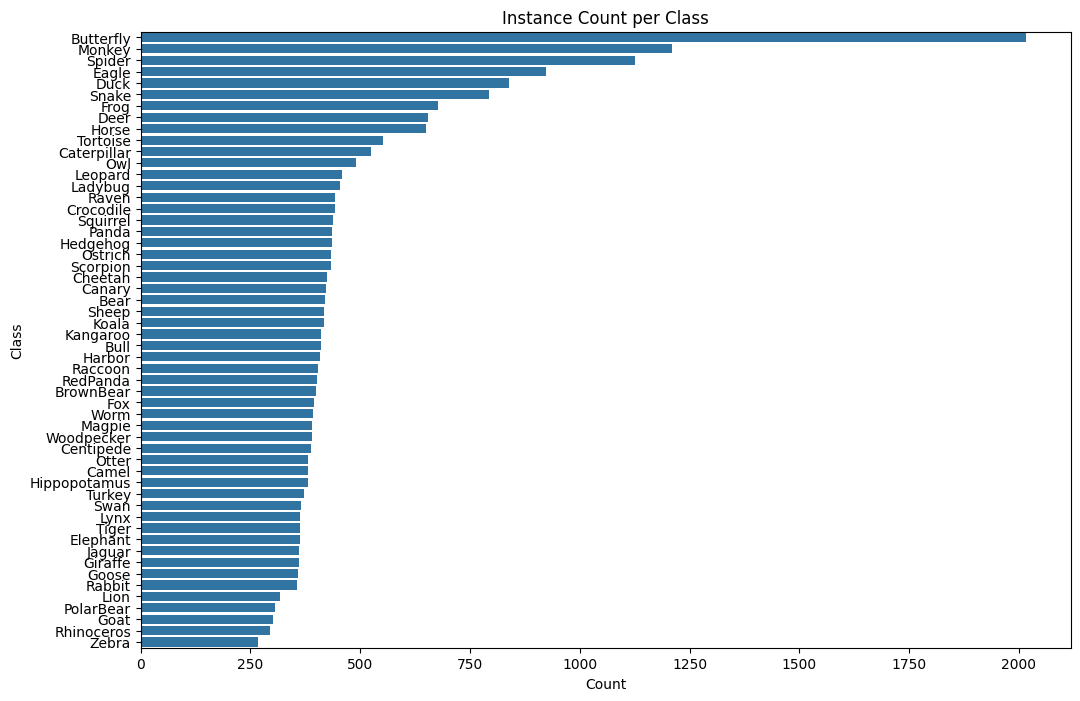

Instance Count Statistics Table:
           Class  Count
6      Butterfly   2017
25        Monkey   1211
15        Spider   1125
24         Eagle    923
13          Duck    838
26         Snake    794
21          Frog    676
23          Deer    655
18         Horse    649
20      Tortoise    551
12   Caterpillar    525
27           Owl    491
2        Leopard    459
16       Ladybug    453
34         Raven    443
8      Crocodile    442
14      Squirrel    439
48         Panda    436
43      Hedgehog    436
41       Ostrich    433
52      Scorpion    433
3        Cheetah    425
7         Canary    423
5           Bear    419
39         Sheep    418
53         Koala    417
22      Kangaroo    410
9           Bull    410
47        Harbor    408
45       Raccoon    405
49      RedPanda    401
36     BrownBear    399
19           Fox    394
46          Worm    392
40        Magpie    391
38    Woodpecker    390
11     Centipede    387
50         Otter    382
10         Camel    381
35  Hip

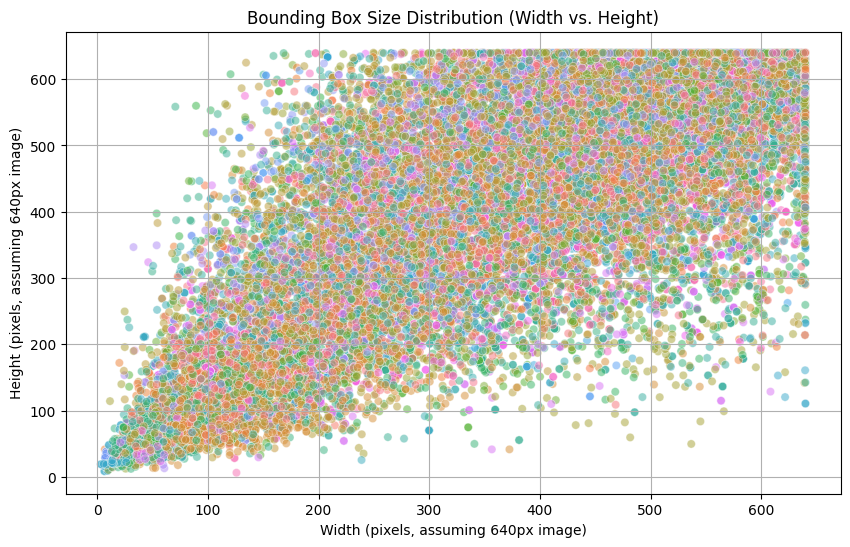

This chart shows the clustering of objects by size.
If all points concentrate in the bottom-left corner -> Data contains many small objects.
If points are scattered -> Object sizes are diverse.

5. DATA SAMPLE VISUALIZATION


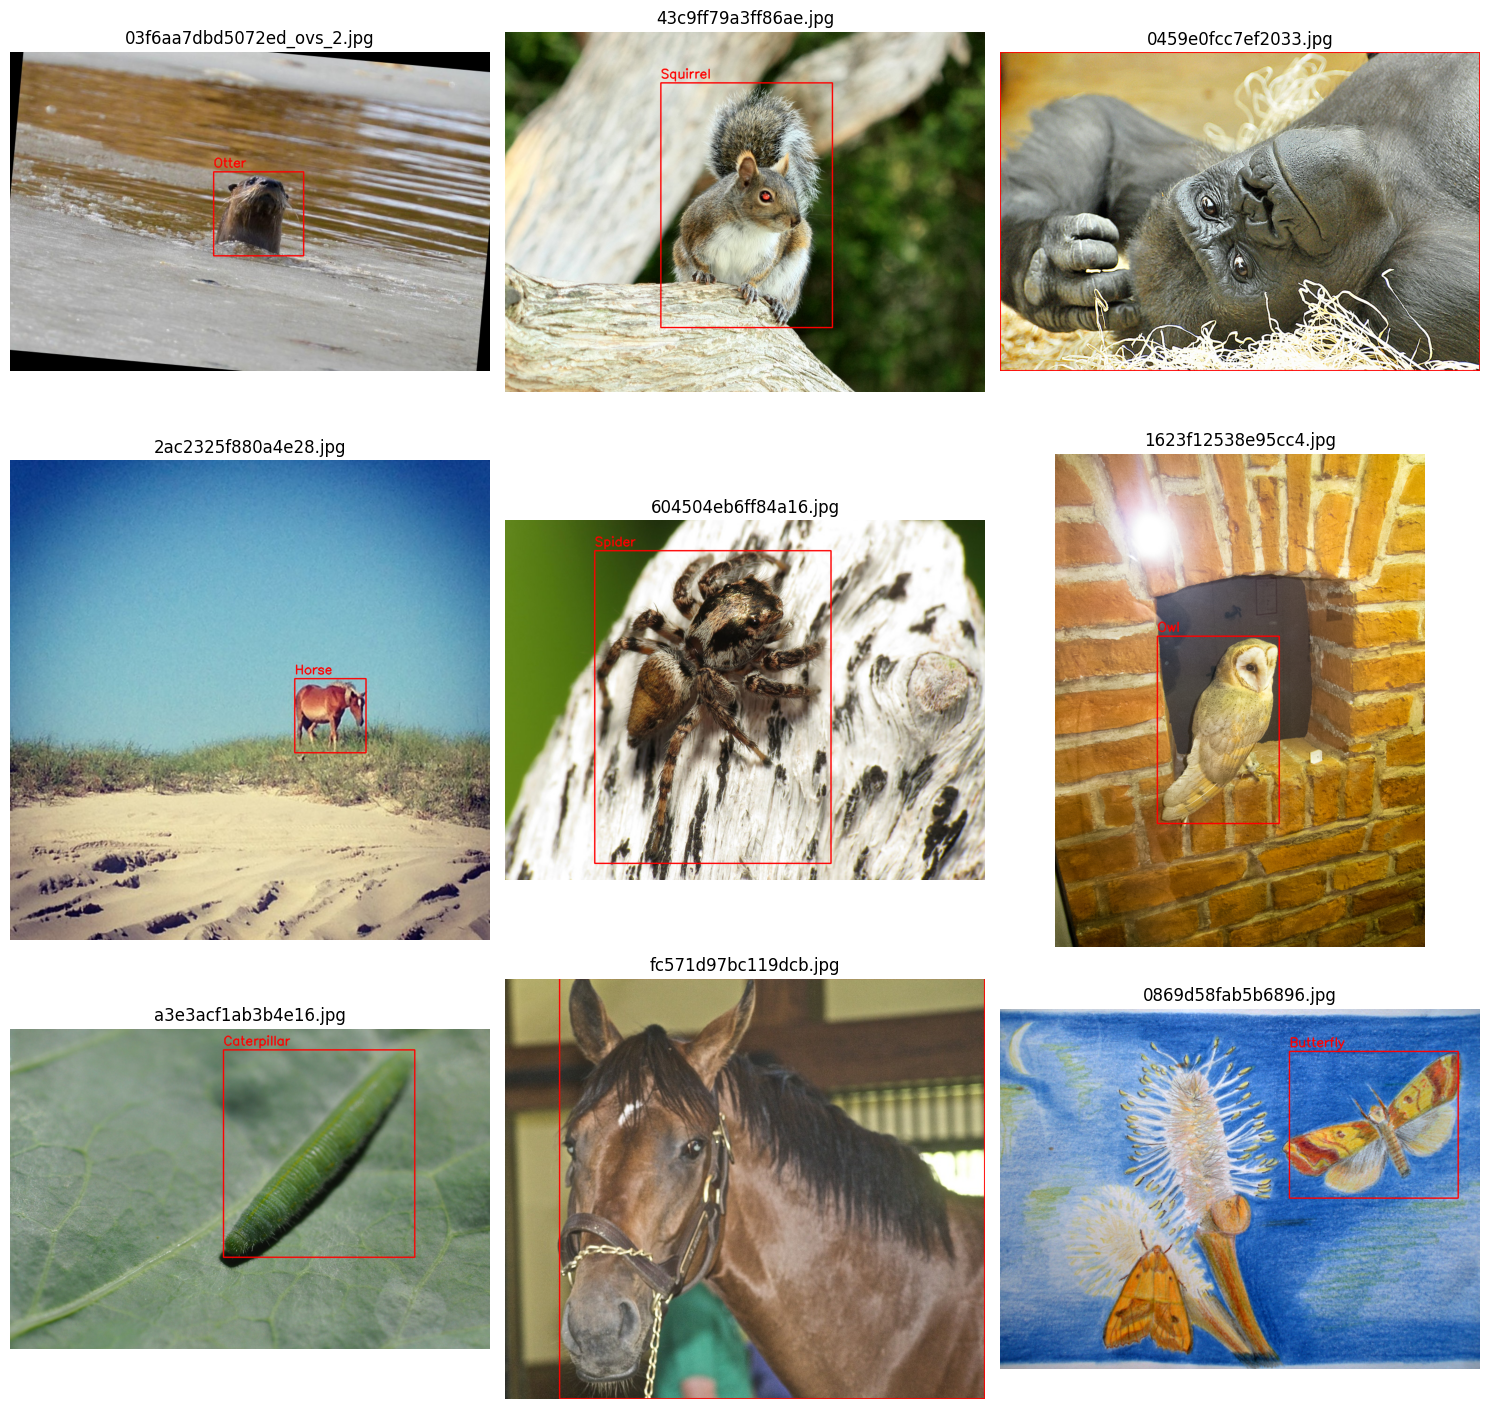

In [16]:
DATA_BALANCED_YAML_PATH = Path(r"C:\Users\Admin\Desktop\NEU 4\Computer Vision\Midterm\Object Detection\Object Detection\Data_balanced\data.yaml")
analyze_dataset(DATA_BALANCED_YAML_PATH)